<a href="https://colab.research.google.com/github/Tinkybala/pole-balancing/blob/main/Pole_Balance_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Balancing Poles with Q-Learning

## Credits

1) [@yue-zhonqi's](https://github.com/yue-zhongqi) github repo at https://github.com/yue-zhongqi/cartpole_colab was used as a template reference for this project. Code from the github repo was also used in the project to set-up the openAI Gym environment

2) The Q(λ) algorithm and the various equations and diagrams used were derived from Sutton and Barto's reinforcement learning bible: ["Reinforcement Learning:
An Introduction"](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)

## Dependencies

In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 38.0 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.7 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.1.0
    Uninstalling setuptools-75.1.0:
      Successfully uninstalled setuptools-75.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.

In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

In [3]:
env = gym.make("CartPole-v1")

## Defining Helper Functions

In [4]:
from collections import defaultdict

As Q-learning is a tabular algorithm with discrete state and actions, whereas the cartpole problem is a continuous one, we have to discretise the continuous states in the environment into discrete bins.

Here we define a function to determine which bin a continuous state is in.

In the cartpole environment, Cart Velocity and Pole Angular Velocity have infinite range. In practice, the cart and pole usually does not reach very extreme velocities and angular velocities so we treat their minimum and maximum as -4 and 4 respectively.

In [5]:
def bin_index(value, type, n_bins):
  if type == 1 or type == 3:
    min_val = -4
    max_val = 4
  else:
    min_val = env.observation_space.low[type]
    max_val = env.observation_space.high[type]
  bin_index = math.floor(((value - min_val) / (max_val - min_val)) * n_bins)

  bin_index = min(bin_index, n_bins - 1)
  bin_index = max(bin_index, 0)

  return bin_index

A simplified ε-greedy policy is used

In [38]:
def policy(observation, ε):
  if np.random.rand() < ε:
    action = env.action_space.sample()  # Random action
  else:
      action = np.argmax(Q[observation])  # Greedy action
  return action

# Agent Training

The approach to the problem is based on Q-learning with some additional tricks to help the Q-learning agent learn better.

## 1) Reward Shaping

Additional rewards based on domain-knowledge based heuristics are given to help the agent learn faster by nudging it towards the correct actions, reducing number of episodes requird for training.

Here, we give positive rewards for small pole angles (<= 5 degrees) and low pole angular velocities (<= 1) and punish with negative rewards otherwise.

## 2) Decaying learning rate (α) and discount factor (γ)

Initial α is set high at 1 to encourage exploration and gradually decreased across episodes to reduce exploration in later episodes when the agent has already learnt from earlier explorations and now require more stable actions

Similarly, γ is also decayed such that the agent prioritises long term rewards at the start but starts to prioritise short-term rewards in later episodes

## 3) Eligibility Traces

In Reinforcement Learning algorithms based on updating the policies like Monte Carlo Control and Q-Learning, we update the action values Q(s,a) based on the cumulative rewards for state-actions pairs in the episodes.

In Monte Carlo, we finish the entire episode and then calculate the actual cumulative rewards for each state.

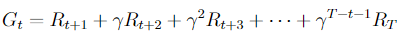

In Q-Learning, we estimate the cumulative rewards by taking one step and adding the reward for the step with the estimated cumulative reward of the next state-action pair (bootstrapping).

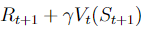

It is possible to do more than one step before doing the boostrapping. For example, 2-steps is possible!

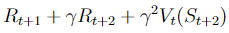


There exists a whole range of n-steps TD that is possible. TD(λ) return takes this idea to the extreme and takes a weighted average of all possible n-steps TD returns. Here the Gt term refers to the n-step TD return for each n. The (1-λ) scales the infinite sum of λ^(n-1) which is a geometric progression back to 1.

The smaller step returns have a higher weightage indicating a greater emphasis on more recent rewards from recent actions. This will be more apparent in the backward view of the TD(λ) return

This is known at the forward view

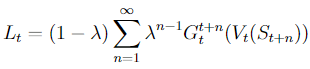

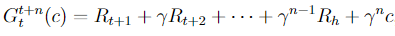

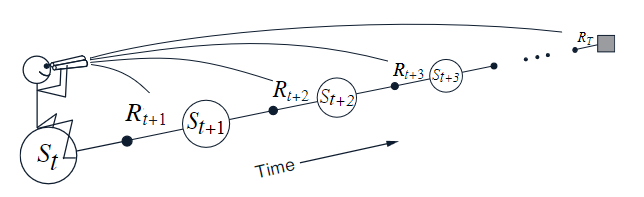

The above diagram illustrates the forward view, similar to that of the Monte Carlo and Q-Learning algorithms

In the backward view, an additional memory variable called the eligibility trace is used

image.png

At each time step, the eligibility trace for each state is decayed. For the state that is just visited the eligibility trace is incremented by 1.

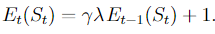

The eligibility trace thus acts as a memory mechanism that keeps track of the most recently visited states.

Then as usual, we take the difference between our estimated cumulative rewards and the current value and scale it except this time we not only scale by α but also by the eligibility trace.

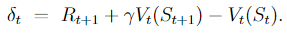

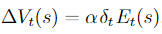

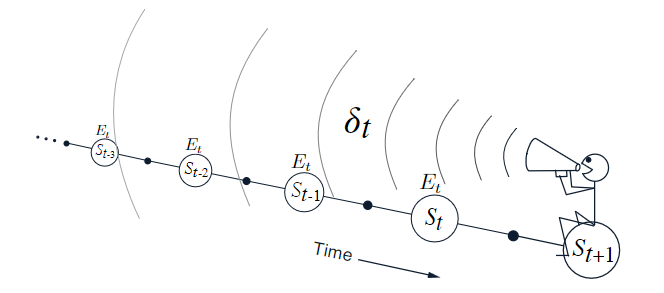

The above is an illustration of the backward view

We can also adapt the above TD(λ) for Q values instead of V values for Q-learning.

It has been proven that the forward and backward views are mathematically equivalent.

The benefit of using TD(λ) returns is that we are able to attribute rewards to not just the immediate preceding action but also to many previous actions. This allows the agent to have delayed rewards which could be helpful for learning in an environment with very sparse and spread out rewards. The following diagram illustrates this benefit.

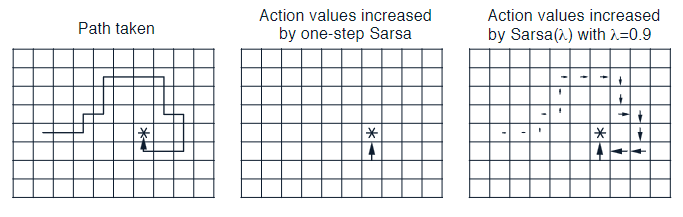

For this project, Watkin's Q(λ) is implemented.

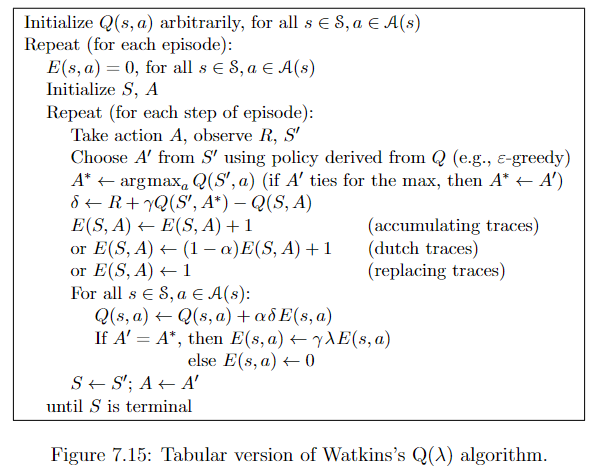

In [10]:
episodes = 500
α = 1
γ = 0.9
Q = defaultdict(lambda: np.zeros(2).tolist())
bins = [1,1,8,20]
ε = 1
ε_decay = 0.92; ε_min = 0.01
α_decay = 0.92; α_min = 0.05
λ = 0.4



rewards = []
alpha = []
epsilon = []

#initialise S, A
observation = env.reset()
observation = tuple(map(lambda x : bin_index(x[1], x[0], bins[x[0]]), enumerate(observation))) #convert observation to discrete states
action = policy(observation, ε)

for episode in range(episodes):
  E = defaultdict(lambda: np.zeros(2).tolist()) # The eligiblity trace
  observation = env.reset()
  observation = tuple(map(lambda x : bin_index(x[1], x[0], bins[x[0]]), enumerate(observation)))
  cumulative_reward = 0
  done = False
  alpha.append(α)
  epsilon.append(ε)
  while not done:
    next_observation, reward, done, info = env.step(action) #Take action A, observe R, S'
    initial_reward = reward
    # Additional rewards if agent is a good boi
    if (abs(next_observation[2]) <= 0.087):  # reward small angle
      reward += 0.5
      #print("reward")
    else: reward -= 1

    if (abs(next_observation[3]) <= 1): #reward low angular velocity
      reward += 0.5
    else: reward -= 1
      #print("reward")


    next_observation = tuple(map(lambda x : bin_index(x[1], x[0], bins[x[0]]), enumerate(next_observation))) #convert next_observation to discrete states

    chosen_action = policy(next_observation, ε) #Choose A' from S' using policy derived from Q (argmax for now)
    best_action = np.argmax(Q[next_observation]) # A∗ = argmax Q(S′, a)



    δ  = reward + γ * max(Q[next_observation]) - Q[observation][action] #This is the TD error δ = R + γQ(S′, A∗) − Q(S, A)
    E[observation][action] += 1 # accumulating trace

    #Update states based on action
    for s in E:
      #left
      Q[s][0] += α * δ * E[s][0]
      if chosen_action == best_action:
        E[s][0] = γ * λ * E[s][0]
      else:
        E[s][0] = 0
      #right
      Q[s][1] += α * δ * E[s][1]
      if chosen_action == best_action:
        E[s][1] = γ * λ * E[s][1]
      else:
        E[s][1] = 0
    cumulative_reward += initial_reward
    action = chosen_action # A = A'
    observation = next_observation # S = S'
  print("Episode:", episode, "Cumulative reward:", cumulative_reward)
  #schedulers
  α = max(α_min, α * α_decay)
  ε = max(ε_min, ε * ε_decay)
  rewards.append(cumulative_reward)

Episode: 0 Cumulative reward: 22.0
Episode: 1 Cumulative reward: 40.0
Episode: 2 Cumulative reward: 24.0
Episode: 3 Cumulative reward: 22.0
Episode: 4 Cumulative reward: 66.0
Episode: 5 Cumulative reward: 33.0
Episode: 6 Cumulative reward: 18.0
Episode: 7 Cumulative reward: 11.0
Episode: 8 Cumulative reward: 18.0
Episode: 9 Cumulative reward: 58.0
Episode: 10 Cumulative reward: 71.0
Episode: 11 Cumulative reward: 43.0
Episode: 12 Cumulative reward: 147.0
Episode: 13 Cumulative reward: 85.0
Episode: 14 Cumulative reward: 48.0
Episode: 15 Cumulative reward: 25.0
Episode: 16 Cumulative reward: 167.0
Episode: 17 Cumulative reward: 134.0
Episode: 18 Cumulative reward: 345.0
Episode: 19 Cumulative reward: 500.0
Episode: 20 Cumulative reward: 30.0
Episode: 21 Cumulative reward: 410.0
Episode: 22 Cumulative reward: 220.0
Episode: 23 Cumulative reward: 171.0
Episode: 24 Cumulative reward: 195.0
Episode: 25 Cumulative reward: 262.0
Episode: 26 Cumulative reward: 184.0
Episode: 27 Cumulative rewa

In [11]:
np.mean(rewards)

476.382

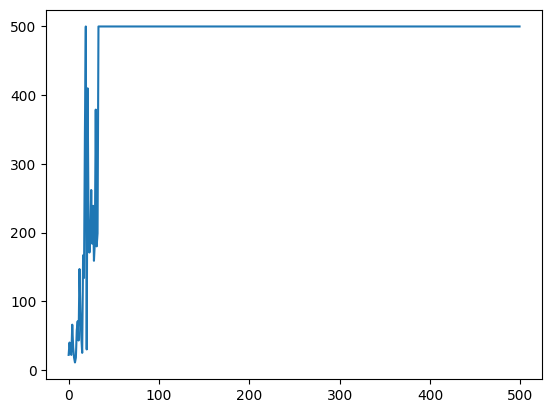

In [12]:
plt.plot(rewards)

## **Task 1:** Development of an RL agent. Demonstrate the correctness of the implementation by sampling a random state from the cart pole environment, inputting to the agent, and outputting a chosen action. Print the values of the state and chosen action in Jupyter notebook.

Reset the environment and let our agent make its action for one time-step

In [16]:
observation = env.reset()
print(f"Observation: {observation}")
observation = tuple(map(lambda x : bin_index(x[1], x[0], bins[x[0]]), enumerate(observation)))
action = np.argmax(Q[observation])
print(f"Chosen Action: {action}")

Observation: [ 0.04365864  0.03702783  0.03370554 -0.03188092]
Chosen Action: 1


## **Task 2:** Demonstrate the effectiveness of the RL agent. Run for 100 episodes (reset the environment at the beginning of each episode) and plot the cumulative reward against all episodes in Jupyter. Print the average reward over the 100 episodes. The average reward should be larger than 195.

## Running the agent for 100 episodes

In [17]:
rewards = []
for i in range(100):
  observation = env.reset()
  done = False
  observed_reward = 0
  while not done:
    observation = tuple(map(lambda x : bin_index(x[1], x[0], bins[x[0]]), enumerate(observation)))
    action = np.argmax(Q[observation])
    observation, reward, done, info = env.step(action)
    observed_reward += reward
  rewards.append(observed_reward)


AttributeError: module 'matplotlib.pyplot' has no attribute 'xlabel'

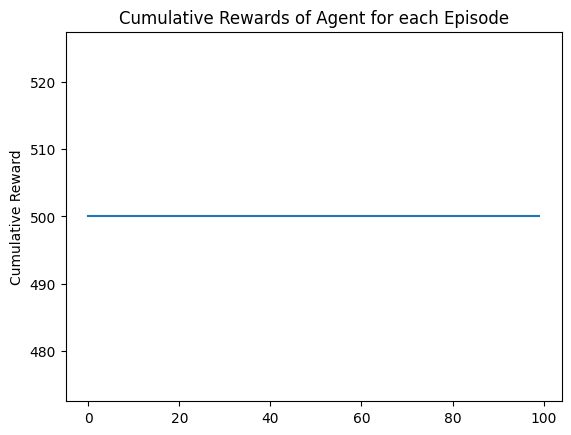

In [35]:
plt.figure()
plt.plot(rewards)
plt.title("Cumulative Rewards of Agent for each Episode")
plt.ylabel("Cumulative Reward")
plt.xlabel("Episode")
plt.show()

In [36]:
np.mean(rewards)

500.0

# **Task 3:** Render one episode played by the developed RL agent on Jupyter. Please refer to the sample code link for rendering code.

# Video

In [37]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
i = 0
while True:
    i += 1
    env.render()
    #your agent goes here
    observation = tuple(map(lambda x : bin_index(x[1], x[0], bins[x[0]]), enumerate(observation)))
    action =  np.argmax(Q[observation])
    observation, reward, done, info = env.step(action)
    if done:
      break;
env.close()
show_video()

/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3147: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3147: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa